In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from evaluators import evaluate_network_ray, evaluate_network
from ray.tune.search.hebo import HEBOSearch

load_dotenv()


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-30 23:59:10,036	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-30 23:59:10,163	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


True

In [2]:
# Assuming feature_df and targets_df are already defined
data_dir = os.getenv("DATA")
encoded_df = pd.read_csv(Path(data_dir) / "encoded_df.csv")
targets_df = pd.read_csv(Path(data_dir) / "target.csv")
encoded_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Kundentreue,Regional_Code_0,...,Vertriebskanal_152.0,Vertriebskanal_153.0,Vertriebskanal_154.0,Vertriebskanal_155.0,Vertriebskanal_156.0,Vertriebskanal_157.0,Vertriebskanal_158.0,Vertriebskanal_159.0,Vertriebskanal_160.0,Vertriebskanal_163.0
0,1.0,1.0,44.0,1.0,0.0,2.0,1.0,40454.0,217.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,76.0,1.0,0.0,0.0,0.0,33536.0,183.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,47.0,1.0,0.0,2.0,1.0,38294.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,21.0,1.0,1.0,1.0,0.0,28619.0,203.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,29.0,1.0,1.0,1.0,0.0,27496.0,39.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sub_encoded_df = encoded_df.sample(n=10000, random_state=42)

minmax_df = pd.DataFrame(scaler.fit_transform(sub_encoded_df.drop(columns="id")),
                         columns=encoded_df.columns.difference(["id"]))

In [4]:
ids = sub_encoded_df.id
y = targets_df.set_index("id").loc[ids]["Interesse"].values
X = minmax_df.values
X.shape

(10000, 216)

In [5]:
from evaluators import evaluate_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Always check that you are sane, especially when you think you are :)
# evaluate_model(X, y, model=RandomForestClassifier(random_state=42), n_splits=3)
# evaluate_model(X,
#                y,
#                model=LogisticRegression(random_state=42, max_iter=1000),
#                n_splits=3)
# evaluate_network(X, y)

In [7]:
# evaluate_network_ray(X,
#                      y,
#                      lr=0.001,
#                      batch_size=16,
#                      layer_sizes=[128,64],
#                      dropout_rate=0.0,
#                      weight_decay=0.0,
#                      lr_decay_gamma=0.0)

In [8]:
X_id = ray.put(X)
y_id = ray.put(y)

def train_dnn(config):
    X = ray.get(X_id)
    y = ray.get(y_id)
    _, _, f1 = evaluate_network_ray(X,
                                    y,
                                    lr=config["learning_rate"],
                                    batch_size=config["batch_size"],
                                    layer_sizes=config["layer_sizes"],
                                    dropout_rate=config["dropout_rate"],
                                    weight_decay=config["weight_decay"],
                                    lr_decay_step=config["lr_decay_step"],
                                    lr_decay_gamma=config["lr_decay_gamma"])


def train_model(config):
    train_dnn(config)


search_space = {
    # DNN hyperparameters
    "learning_rate":
        tune.loguniform(1e-6, 1e-2),
    "layer_sizes":
        tune.sample_from(lambda: [tune.choice(range(8,256)).sample()]*tune.choice(range(1,5)).sample()),

    "batch_size":
        tune.choice([1, 4, 8, 16, 32, 64]),
    "dropout_rate":
        tune.uniform(0, 0.5),
    "weight_decay":
        tune.loguniform(1e-5, 1e-2),
    "lr_decay_step":
        tune.choice([3, 5, 7, 10]),
    "lr_decay_gamma":
        tune.uniform(0.1, 0.5),
}

ray.init(num_cpus=8, num_gpus=1, ignore_reinit_error=True)

analysis = tune.run(train_model,
                    config=search_space,
                    num_samples=50,
                    search_alg=HEBOSearch(metric="f1_score", mode="max"),
                    scheduler=ASHAScheduler(metric="f1_score", mode="max"),
                    resources_per_trial={
                        "cpu": 1,
                        "gpu": 1 / 8
                    })

best_config = analysis.get_best_config(metric="f1_score", mode="max")
best_trial = analysis.get_best_trial(metric="f1_score", mode="max")

print("Best config:", best_config)
print("Best F1 Score:", best_trial.last_result["f1_score"])

ray.shutdown()

2024-09-30 23:59:54,099	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66985984 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-09-30 23:59:54,227	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-09-30 23:59:55,019	INFO worker.py:1619 -- Calling ray.init() again after it has already been called.
2024-09-30 23:59:55,021	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_model pid=64101) 


Trial name,epoch,f1_score,learning_rate,loss,pr_auc,roc_auc
train_model_030b28f0,19,0.0201005,2.31071e-08,232.909,0.369606,0.844809
train_model_0de64bdc,19,0,0.000279532,2008.6,0.345882,0.839698
train_model_0dfe1829,19,0,0.000189685,1998.61,0.343111,0.846596
train_model_0fbd79de,19,0,5.77784e-12,140.024,0.176627,0.605805
train_model_1173afc2,0,0,0.00498194,66.1682,0.367939,0.837406
train_model_14bf7f34,19,0,8.05077e-05,441.081,0.364346,0.839426
train_model_1605ec8c,19,0,5.05623e-05,27.9925,0.389756,0.860977
train_model_17b005f0,0,0,0.00186602,534.844,0.357195,0.845773
train_model_213e4b93,19,0,0.000108654,29.861,0.370175,0.844425
train_model_22d927ab,19,0,0.000353777,2059.96,0.311656,0.828312


(train_model pid=64101) Epoch 1, Loss: 1223.36, LR: 0.00, ROC AUC: 0.64, PR AUC: 0.19, F1: 0.24
(train_model pid=64101) 
(train_model pid=64159) 
(train_model pid=64101) Epoch 2, Loss: 1199.39, LR: 0.00, ROC AUC: 0.67, PR AUC: 0.20, F1: 0.00
(train_model pid=64101) 
(train_model pid=64274) 
(train_model pid=64101) Epoch 3, Loss: 1175.47, LR: 0.00, ROC AUC: 0.67, PR AUC: 0.21, F1: 0.00
(train_model pid=64101) 
(train_model pid=64336) 
(train_model pid=64101) Epoch 4, Loss: 1147.58, LR: 0.00, ROC AUC: 0.68, PR AUC: 0.21, F1: 0.00
(train_model pid=64101) 
(train_model pid=64408) 
(train_model pid=64101) Epoch 5, Loss: 1114.99, LR: 0.00, ROC AUC: 0.69, PR AUC: 0.22, F1: 0.00
(train_model pid=64101) 
(train_model pid=64468) 
(train_model pid=64468) 
(train_model pid=64468) 
(train_model pid=64101) 
(train_model pid=64468) 
(train_model pid=64468) 
(train_model pid=64468) Epoch 4, Loss: 134.91, LR: 0.00, ROC AUC: 0.82, PR AUC: 0.30, F1: 0.00 [repeated 5x across cluster] (Ray deduplicates log

2024-10-01 00:17:28,002	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_2024-09-30_23-59-55' in 0.0202s.
2024-10-01 00:17:28,015	INFO tune.py:1041 -- Total run time: 1052.99 seconds (1052.94 seconds for the tuning loop).


(train_model pid=69830) Epoch 20, Loss: 59.81, LR: 0.00, ROC AUC: 0.85, PR AUC: 0.38, F1: 0.00
Best config: {'learning_rate': 2.3185187569298865e-06, 'layer_sizes': [152], 'batch_size': 64, 'dropout_rate': 0.13942815366727146, 'weight_decay': 0.0032504407838847764, 'lr_decay_step': 5, 'lr_decay_gamma': 0.4968867228925017}
Best F1 Score: 0.2103213242453749


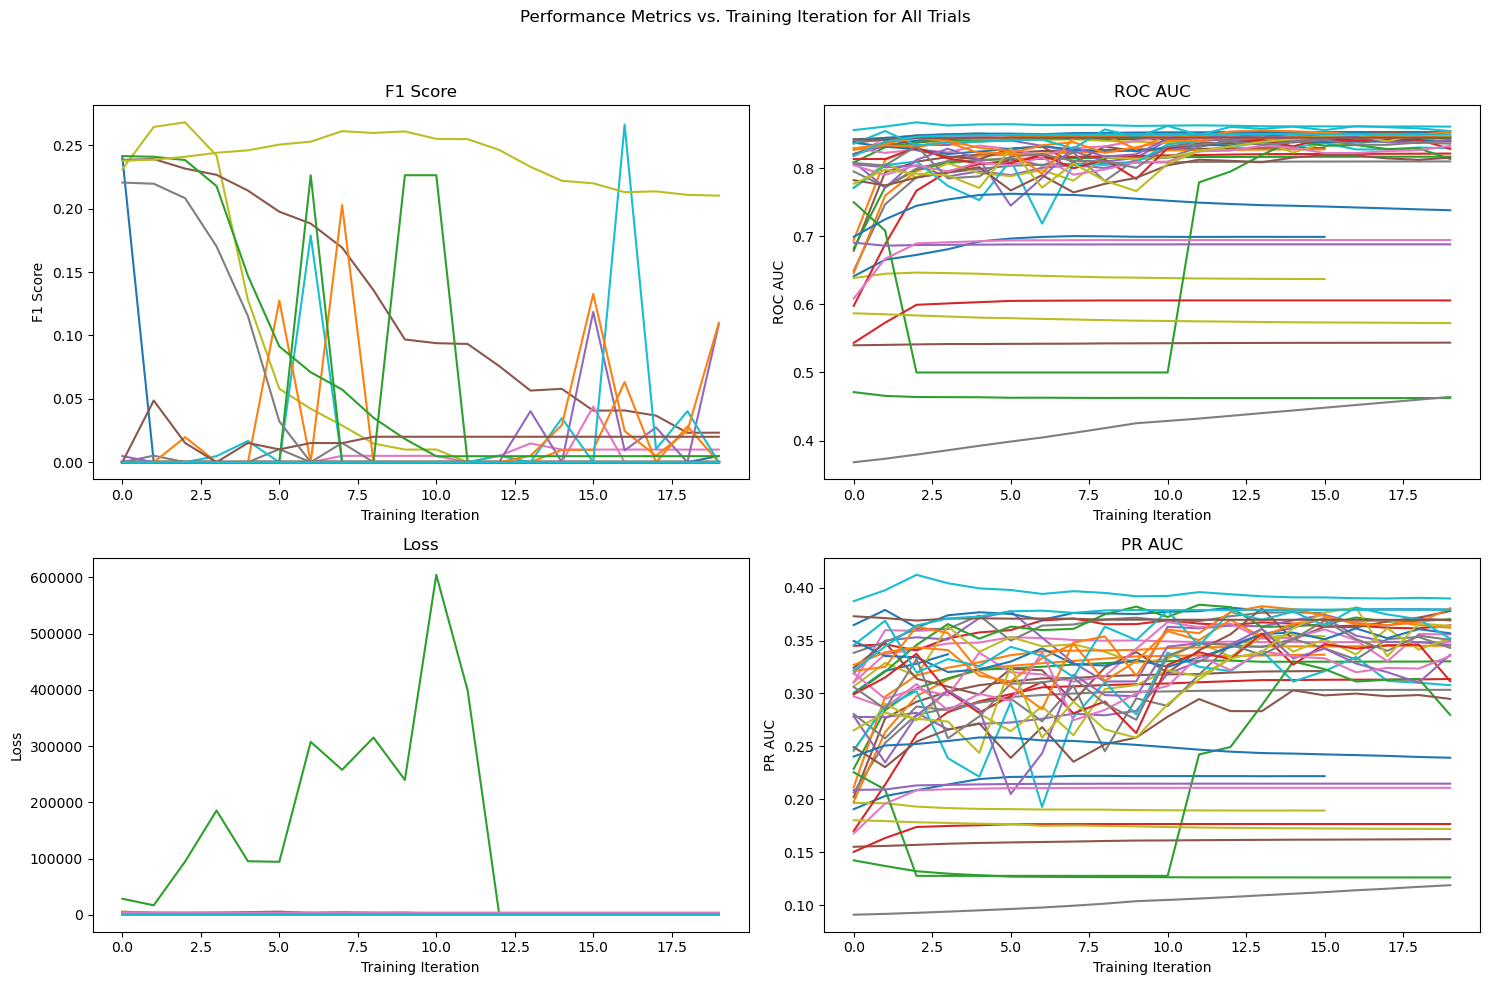

In [9]:
import matplotlib.pyplot as plt
from ray.tune import ExperimentAnalysis

# Assuming 'analysis' is already loaded as you've described
dfs = analysis.trial_dataframes

# Setting up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Performance Metrics vs. Training Iteration for All Trials')

# Titles for each subplot
titles = ['F1 Score', 'ROC AUC', 'Loss', 'PR AUC']
metrics = ['f1_score', 'roc_auc', 'loss',
           'pr_auc']  # assuming these fields exist in your dataframes

# Iterating through each subplot and metric
for ax, metric, title in zip(axs.flatten(), metrics, titles):
    for d in dfs.values():
        if metric in d:
            d[metric].plot(ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel("Training Iteration")
    ax.set_ylabel(title)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect values as needed for your display
plt.show()